In [61]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [62]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [63]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [185]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#engine

In [189]:
# Declare a Base using `automap_base()`
Base = automap_base()
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables
#Base.classes.keys()

In [210]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [191]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [192]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [193]:
# Find the most recent date in the data set.
query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#query.date

In [247]:
# Verify Measurement structure
columns = inspector.get_columns('Measurement')
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

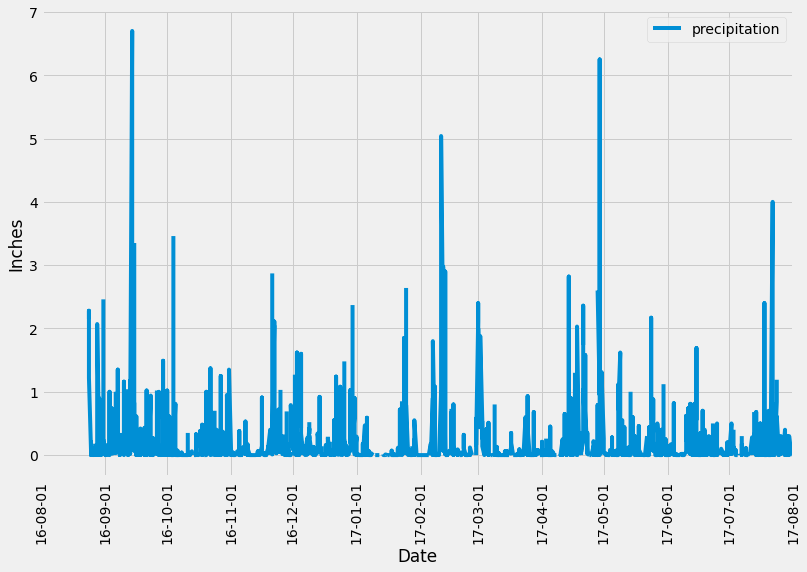

In [204]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date = dt.datetime.strptime(query.date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date)

# Save the query results as a Pandas DataFrame and set the index to the date column
dfres = pd.read_sql(results.statement, results.session.bind)

# Sort the dataframe by date
## While I think sqlalchemy returned a result sorted by date, I will sort it again for kicks
## Oh and that date isn't a date, its an object
fix_dfres = pd.to_datetime(dfres["date"])
dfres['date'] = fix_dfres
sorted_dfres = dfres.sort_values(by='date',ignore_index=True)

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
#from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot('date', 'prcp', data=sorted_dfres)


fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_month)

# Fix the tick label dates to eliminate the minutes, seconds
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))

# Round to the nearest month and align the xticks there
datemin = np.datetime64(sorted_dfres['date'].iloc[0],'M')
datemax = np.datetime64(sorted_dfres['date'].iloc[-1],'M') 
ax.set_xlim(datemin, datemax)

# Rotate and rightalign the x labels, legend, axis labels and show it
plt.xticks(rotation = 90)
plt.legend(["precipitation"],loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
plt.show();

In [209]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# This lacks detail, I will try to come back to it.
sorted_dfres.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [286]:
# Design a query to calculate the total number stations in the dataset
query = session.query(Station.station).count()
print("The number of Stations is:", query)

The number of Stations is: 9


In [285]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
#
## This worked in PG, Now try to make this work in sqlalchemy
## select count(m.id), m.station from measurement m
## group by(m.station)
## order by(count(m.id)) desc
from sqlalchemy.sql import text
#sel_statement = text("""select count(measurement.id), measurement.station from measurement group by (measurement.station) order by (count(measurement.id)) desc""")
sel_statement = text("""select count(m.id), m.station from measurement m group by (m.station) order by (count(m.id)) desc""")
query = session.execute(sel_statement)

## that only took 2 days, query text tip from here - https://chartio.com/resources/tutorials/how-to-execute-raw-sql-in-sqlalchemy/
for row in query:
    print("Station:",row[1], "had", row[0],"unique observation counts.")

Station: USC00519281 had 2772 unique observation counts.
Station: USC00519397 had 2724 unique observation counts.
Station: USC00513117 had 2709 unique observation counts.
Station: USC00519523 had 2669 unique observation counts.
Station: USC00516128 had 2612 unique observation counts.
Station: USC00514830 had 2202 unique observation counts.
Station: USC00511918 had 1979 unique observation counts.
Station: USC00517948 had 1372 unique observation counts.
Station: USC00518838 had 511 unique observation counts.


In [280]:
## Nix this - # Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
##
## Question from instructions - which station had the highest number of observations:
query = session.execute(sel_statement)
for row in query:
    print("The Station with the highest number of Observations is: ",row[1])
    break


The Station with the highest number of Observations is:  USC00519281


In [325]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Save the query results as a Pandas DataFrame and set the index to the date column
#dfres = pd.read_sql(results.statement, results.session.bind)
#date
results = session.query(func.count(Measurement.tobs),Measurement.tobs).filter(Measurement.date > date).filter(Measurement.station == 'USC00519281').group_by(Measurement.tobs)

In [326]:
# Save the query results as a Pandas DataFrame and set the index to the date column
dfres = pd.read_sql(results.statement, results.session.bind)
dfres

,count_1,tobs
0,3,59.0
1,2,60.0
2,1,61.0
3,6,62.0
4,4,63.0
5,3,64.0
6,7,65.0
7,5,66.0
8,15,67.0
9,12,68.0


AttributeError: 'function' object has no attribute 'hist'

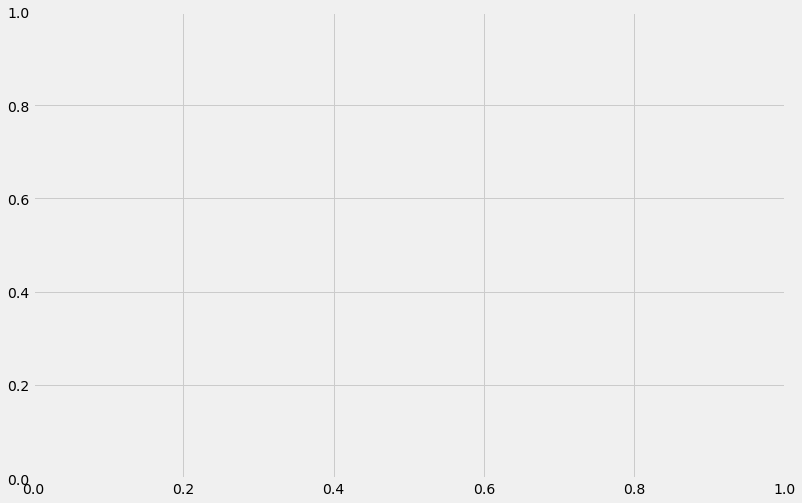

In [336]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot('tobs', 'count_1', data=dfres)
#ax.hist(x,bins=12)

#fmt_month = mdates.MonthLocator(interval=1)
#ax.xaxis.set_major_locator(fmt_month)

# Fix the tick label dates to eliminate the minutes, seconds
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))

# Round to the nearest month and align the xticks there
#datemin = np.datetime64(sorted_dfres['date'].iloc[0],'M')
#datemax = np.datetime64(sorted_dfres['date'].iloc[-1],'M') 
#ax.set_xlim(datemin, datemax)

# Rotate and rightalign the x labels, legend, axis labels and show it
#plt.xticks(rotation = 90)
#ax.hist(x, bins=12)
#ax.hist(y, bins=12)
plt.legend(["precipitation"],loc=0)
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
plt.show();

# Close session

In [ ]:
# Close Session
session.close()